In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt


from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor


In [2]:
path = '../../data/clean/'
SEED = 12
unhcr = pd.read_csv(path + 'unhcr.csv', engine='pyarrow')


In [3]:
id_var = unhcr.Id.unique().tolist()


In [4]:
unhcr['year'] = pd.to_datetime(unhcr['year'], format='%Y')
unhcr["year"] = unhcr["year"].dt.year

In [5]:
# Create train/test split
test_time_start = 2018
test_time_end = 2021
train = unhcr.loc[unhcr.year < test_time_start]
test = unhcr.loc[(unhcr.year >= test_time_start) & (unhcr.year <= test_time_end)]

In [15]:
#y_naive = model_helpers.apply_naive_prediction(train, test, target="newarrival", 
 #                                             country_var='Id'
  #                                            )


In [14]:
#mse_naive = mean_squared_error(y_pred=y_naive, y_true=test.newarrival, squared=False)
#print("Mse Naive RW: " + str(mse_naive))

Mse Naive RW: 4681.263424950381


In [7]:
mse_naive = 4681.263424950381

Adding gtrends with interactions

In [8]:
visatrend = pd.read_csv("../trends/trends_downloads/interactions_full/interactions visa.csv")

In [9]:
# Extract country name and convert to ISO-3 code
visatrend["name"] = visatrend['keyword_en'].str.split(' ', expand=True)[1]
names = visatrend["name"].unique()
df = pd.DataFrame(names, columns=["name"])
df = df[df["name"].isnull()==False]
df["iso_d"] = df["name"].apply(model_helpers.name_to_iso3)
visatrend = pd.merge(visatrend, df, on="name", how="left")


In [10]:
iso_o_list = visatrend.region.unique()
df = pd.DataFrame(iso_o_list, columns=["region"])
df = df[df["region"].isnull()==False]
df["iso_o"] = df["region"].apply(model_helpers.convert_iso2_to_iso3)
visatrend = pd.merge(visatrend, df, on="region", how="left")


In [11]:
visatrend = visatrend.drop(columns=["country", "language", "name", "region", "keyword_en", "keyword"])
visatrend_av = visatrend.groupby(['iso_o', 'iso_d', 'date']).mean().reset_index()
visatrend_max = visatrend.groupby(['iso_o', 'iso_d', 'date']).max().reset_index()
visatrend_av = visatrend_av.rename(columns={"trends_index":"visa_avg"})
visatrend_max = visatrend_max.rename(columns={"trends_index":"visa_max"})


In [12]:
visa_final = pd.merge(visatrend_av, visatrend_max, on=["iso_o", "iso_d", "date"], how="left")
print(visa_final.shape)
visa_final.head()


(710424, 5)


,iso_o,iso_d,date,visa_avg,visa_max
0,AFG,AUS,2005-01-01,0.0,0
1,AFG,AUS,2005-02-01,0.0,0
2,AFG,AUS,2005-03-01,0.0,0
3,AFG,AUS,2005-04-01,0.0,0
4,AFG,AUS,2005-05-01,0.0,0


In [13]:
# visa_final.to_csv("../../data/clean/visa_full_gtrend.csv", index=False)

In [14]:
visa_final

,iso_o,iso_d,date,visa_avg,visa_max
0,AFG,AUS,2005-01-01,0.0,0
1,AFG,AUS,2005-02-01,0.0,0
2,AFG,AUS,2005-03-01,0.0,0
3,AFG,AUS,2005-04-01,0.0,0
4,AFG,AUS,2005-05-01,0.0,0
...,...,...,...,...,...
710419,ZWE,ZWE,2022-08-01,10.0,10
710420,ZWE,ZWE,2022-09-01,12.0,12
710421,ZWE,ZWE,2022-10-01,11.0,11
710422,ZWE,ZWE,2022-11-01,11.0,11


### Preprocessing visa trends

In [15]:
visa_smoothed = visa_final.apply(model_helpers.smooth_spikes_2)
visa_smoothed["date"] = pd.to_datetime(visa_smoothed["date"])

In [16]:
visa_smoothed['year'] = visa_smoothed['date'].dt.year
visa_smoothed['month'] = visa_smoothed['date'].dt.month
visa_smoothed = visa_smoothed.drop(columns=["date"])


In [17]:
final_keywords_list = visa_smoothed.columns[~visa_smoothed.columns.isin(['year', 'month', 'iso_o', 'iso_d'])]

In [18]:
window_sizes = [4, 7] # rolling sums for the last 3 and 6 months
group_cols = ['iso_o', 'year']
value_cols = final_keywords_list

panel_trends = model_helpers.generate_rolling_sum_variables(visa_smoothed, group_cols, value_cols, window_sizes, date_col='month')

panel_trends = panel_trends[panel_trends["month"]==1]

panel_trends

,iso_o,iso_d,visa_avg,visa_max,year,month,rolling_sum_past_3_visa_avg,rolling_sum_past_6_visa_avg,rolling_sum_past_3_visa_max,rolling_sum_past_6_visa_max
0,AFG,AUS,0.0,0.0,2005,1,0.0,0.0,0.0,0.0
12,AFG,AUS,0.0,0.0,2006,1,0.0,0.0,0.0,0.0
24,AFG,AUS,0.0,0.0,2007,1,0.0,0.0,0.0,0.0
36,AFG,AUS,0.0,0.0,2008,1,0.0,0.0,0.0,0.0
48,AFG,AUS,0.0,0.0,2009,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
709548,ZWE,IRL,1.0,1.0,2022,1,2.0,4.0,2.0,4.0
709764,ZWE,ITA,0.0,0.0,2022,1,1.0,4.0,1.0,4.0
709980,ZWE,NLD,0.0,0.0,2022,1,1.0,3.0,1.0,3.0
710196,ZWE,ZMB,1.0,1.0,2022,1,2.0,3.0,2.0,3.0


In [19]:
trends_final = panel_trends.fillna(0)

In [20]:
internet = pd.read_csv("../../data/raw/Internet penetration_WB.csv").drop(columns=["Country Name", "Indicator Name", "Indicator Code"])

value_vars = internet.columns.difference(['Country Code']).tolist()

internet_long = pd.melt(internet, id_vars=['Country Code'], value_vars=value_vars,
                  var_name='year', value_name='internet')
internet_long["year"] = pd.to_datetime(internet_long["year"])
internet_long['year'] = internet_long['year'].dt.year
internet_long = internet_long[internet_long["year"]>=2000]

# Because this has only weighting purpose, I'll fill nans with 1 in the version to multiply
internet_long = internet_long.copy().fillna(1)
internet_long = internet_long.rename(columns={"Country Code":"iso_o"})

In [21]:
data_outflows_2005 = unhcr[unhcr["year"]>=2005]
data_outflows_2005 = data_outflows_2005[["iso_o", "iso_d", "year", "newarrival", "pop_o"]]
trends_merged = pd.merge(data_outflows_2005, trends_final, on=["iso_o", "iso_d", "year"], how="left")

trends_merged = pd.merge(trends_merged, internet_long, on=["iso_o", "year"], how='left')


In [22]:
trends_merged.shape

(772200, 13)

In [23]:
float_columns = trends_merged.select_dtypes(include=['float64']).columns
trends_merged = trends_merged.fillna(0)
trends_merged[float_columns] = trends_merged[float_columns].astype(int)


# Create a list of variables to weight
variables_to_multiply = [col for col in trends_merged.columns if col not in ['iso_o', 'iso_d', 'year', 'pop_o', 'internet', 'newarrival']]

# Multiply the variables by 'pop_o' and 'internet'
trends_merged[variables_to_multiply] = trends_merged[variables_to_multiply].multiply(trends_merged['pop_o'], axis=0).multiply(trends_merged['internet'], axis=0)

# Drop non-multiplied variables, 'pop_o', and 'internet'
# columns_to_drop = ['internet', 'pop_o]
# trends_merged.drop(columns=columns_to_drop, inplace=True)

trends_merged.shape
trends_merged.head()

,iso_o,iso_d,year,newarrival,pop_o,visa_avg,visa_max,month,rolling_sum_past_3_visa_avg,rolling_sum_past_6_visa_avg,rolling_sum_past_3_visa_max,rolling_sum_past_6_visa_max,internet
0,AFG,ALB,2005,0,20,0,0,0,0,0,0,0,1
1,AFG,ALB,2006,0,21,0,0,0,0,0,0,0,2
2,AFG,ALB,2007,0,22,0,0,0,0,0,0,0,1
3,AFG,ALB,2008,0,22,0,0,0,0,0,0,0,1
4,AFG,ALB,2009,0,23,0,0,0,0,0,0,0,3


In [24]:
trends_merged["target"] = trends_merged.groupby(['iso_o', 'iso_d']).newarrival.shift(-1)
trends_merged = trends_merged.drop(columns=["newarrival"])

## Testing a simple model: 

Visa trends + dyad fixed effects (+ controls: internet + pop_o)

In [25]:
# ohe = OneHotEncoder()
be = BinaryEncoder() # doing be on everything yields better results
cont_scaler = RobustScaler()

# binary_cols = ['iso_o']
# ohe_cols = ['iso_o_continent','typeOfViolence_o']
binary_cols = ['iso_o', 'iso_d']

# numerical_cols = list(set(unhcr.columns) - set(binary_cols + ohe_cols + ['year', 'ref_outflow']))
numerical_cols = list(set(trends_merged.columns) - set(binary_cols  + ['year', 'target']))

from sklearn.compose import ColumnTransformer

transform_cols = ColumnTransformer(
    [
        ('cat1', be, binary_cols),
   #     ('cat2', ohe, ohe_cols),
        ('num', cont_scaler, numerical_cols)
    ],
    remainder='passthrough'
)

rf_pipe = Pipeline([('preprocessing', transform_cols),
                    ('rf', RandomForestRegressor(random_state=SEED, n_jobs=-1))])

In [26]:
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [27]:
len(y_test)

154440

In [28]:
rf_pipe.fit(X_train, y_train)

y_pred = rf_pipe.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
mse_trends_weighted = mean_squared_error(y_test, y_pred, squared=False)

print("RMSE outflows - GTrends only (weighted): " + str(mse_trends_weighted))
print("Relative RMSE to Naive predictions: " + str(mse_trends_weighted/mse_naive))

RMSE outflows - GTrends only (weighted): 2907.3954353535582
Relative RMSE to Naive predictions: 0.6210706750356343


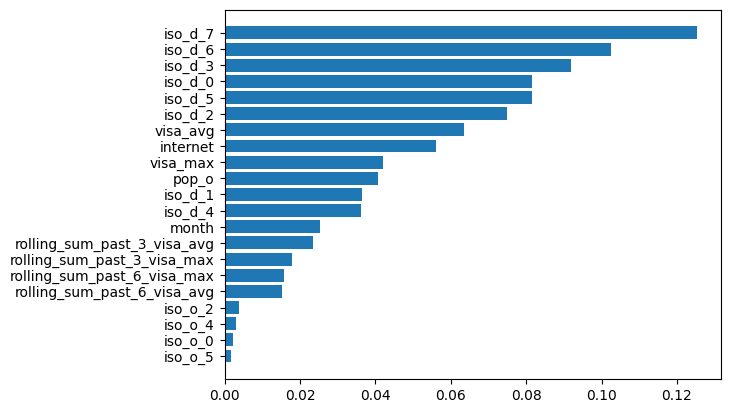

In [29]:
importances = rf_pipe.named_steps['rf'].feature_importances_

# Get column names from ColumnTransformer object
column_names = list(rf_pipe.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out()) + numerical_cols


# Map feature importances to column names
feature_importances = dict(zip(column_names, importances))

indexes = model_helpers.feature_imp_more(feature_importances)

Countries fixed effects are important, also the controls internet and population, but the visa features are working :) !

With rw and log transformation:

In [30]:
X_train_list, X_test_list, y_train_list, y_test_list = model_helpers.train_test_split_rw(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [31]:
mse_visa_log_dict = {}
predictions_list = []

# Iterate over the test sets for each year
for year, X_train, X_test, y_train, y_test in zip(range(test_time_start, test_time_end + 1), X_train_list, X_test_list, y_train_list, y_test_list):


    epsilon = 1e-8
    y_train_log = np.log(y_train + epsilon)

    rf_pipe.fit(X_train, y_train_log)

    # Predict on test set and transform back to original scale
    y_pred_log = rf_pipe.predict(X_test)
    y_pred = np.exp(y_pred_log) 
    
    mse_visa_log_year = mean_squared_error(y_test, y_pred, squared=False)

    mse_visa_log_dict[year] = mse_visa_log_year

    print("*********")
    print("Year: " + str(year))
    print("X_train uses data until: " + str(X_train.year.max()))
    print("RMSE using just gtrends: " + str(mse_visa_log_year))

    # Store predicted values in DataFrame
    predictions_list.append(pd.DataFrame({"year": [year] * len(X_test),
                                            "iso_o": X_test["iso_o"].values,
                                            "y_pred_visa_log_rw": y_pred}))

    # Concatenate DataFrames from the list
    predictions_df_visa_log = pd.concat(predictions_list, ignore_index=True)

*********
Year: 2018
X_train uses data until: 2017
RMSE using just gtrends: 3744.046211420125
*********
Year: 2019
X_train uses data until: 2018
RMSE using just gtrends: 1477.819499413445
*********
Year: 2020
X_train uses data until: 2019
RMSE using just gtrends: 1961.8427539487052
*********
Year: 2021
X_train uses data until: 2020
RMSE using just gtrends: 592.9487822427641


In [32]:
# recuperating y_test for the comparison
X_train, X_test, y_train, y_test = model_helpers.train_test_split(trends_merged, 'target', test_time_start, test_time_end, 'year')

In [33]:
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_log.y_pred_visa_log_rw, squared=False))
print(mean_squared_error(y_true=y_test, y_pred=predictions_df_visa_log.y_pred_visa_log_rw, squared=False)/mse_naive)

2292.4952024292043
0.4897171969025656


Saving the visa preprocessed features:

In [35]:
visa_to_save = trends_merged.drop(columns='target')

In [37]:
visa_to_save.to_csv(path + "visa_interacted_preprocessed.csv", index=False)